# Netflix appetency - Consumer Classification

![title](https://i.pcmag.com/imagery/reviews/05cItXL96l4LE9n02WfDR0h-5.fit_scale.size_1028x578.v1582751026.png)


## Goal:

- Classify consumers according to their appetite to subscribe to Netflix.

## Metric:

- The metric used is AUC

## Data:

- train.csv - the training set. it consists of an id column, the customers features, and a target column: target.
- test.csv - the test set. it consists of everything in train.csv except target.

For reasons of confidentiality, the data is anonymized and augmented.

## Importing Libraries

In [ ]:
pip install catboost --no-cache-dir

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


from catboost import CatBoostClassifier

## Reading Data

In [6]:
train_df = pd.read_csv('D:/D_ST/Git_Profile/Netflix Appentency/Data/train_data.csv.gz', compression= 'gzip')
test_df = pd.read_csv('D:/D_ST/Git_Profile/Netflix Appentency/Data/test_data.csv.gz', compression= 'gzip')

In [7]:
print(train_df.shape)
print(test_df.shape)
train_df.head(5)

(70000, 509)
(30000, 508)


,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506
0,0,0,C0,C0,C1,C5,C11,37.56,54.756667,54.756667,...,0,0,0,0,0,0,0,0,0,0
1,1,0,C0,C0,C3,C5,C1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,0,C0,C0,C3,C5,C2,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,3,0,C0,C0,C1,C5,C1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4,1,C0,C0,C3,C3,C11,37.48,37.480000,37.161333,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_df.describe()

,id,target,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,...,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506
count,70000.000000,70000.000000,25424.000000,26389.000000,27792.000000,25424.000000,26389.000000,27792.000000,25424.000000,26389.000000,...,70000.000000,70000.0,70000.000000,70000.0,70000.000000,70000.0,70000.000000,70000.000000,70000.0,70000.000000
mean,50025.281314,0.298186,40.124969,39.975888,38.937569,32.120109,31.533970,30.517150,2.891956,2.847829,...,-3.138300,0.0,-3.138300,0.0,3.138300,0.0,3.138300,-3.138300,0.0,3.138300
std,28878.675532,0.457465,21.415242,20.591512,20.364727,13.766195,13.330736,13.692785,2.294987,2.267976,...,17.344944,0.0,17.344944,0.0,17.344944,0.0,17.344944,17.344944,0.0,17.344944
min,0.000000,0.000000,-217.460000,-89.690000,-66.497000,-219.180000,-89.690000,-49.390000,-30.850000,-19.813333,...,-99.000000,0.0,-99.000000,0.0,0.000000,0.0,0.000000,-99.000000,0.0,0.000000
25%,24999.750000,0.000000,32.470000,32.470000,31.923333,30.750000,28.600000,27.215000,2.500000,2.500000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
50%,50030.500000,0.000000,37.480000,37.560000,37.030667,34.160000,33.320000,31.710000,2.500000,2.500000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
75%,75027.250000,1.000000,48.062750,48.490000,47.726458,35.830000,35.830000,35.830000,2.500000,2.500000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
max,99999.000000,1.000000,403.880000,639.756667,511.091667,148.360000,136.030000,136.030000,47.000000,53.556667,...,0.000000,0.0,0.000000,0.0,99.000000,0.0,99.000000,0.000000,0.0,99.000000


- Feature_500, Feature_502, Feature_505 have min max mean everything as 0.
- Feature_497, Feature_499, Feature_504 oddly sahre same min, mean and Standard deviation.
- Some columns has only one categorical variable.
- Need to take care of missing values.

## Handeling Missing Values

In [9]:
#Creating Function to calculate % of missing vazlues in each column
def find_missings_percnt(df):
    if df.isna().sum().sum()>0:
        ColumnName , PercentMissing = list(), list()
        for column in df.columns:
            if df[column].isnull().sum():
                ColumnName.append(column)
                PercentMissing.append((df[column].isnull().sum()/len(df[column])*100))
        missing_percent_df = pd.DataFrame({'Feature':ColumnName, 'PercentMissing':PercentMissing})
        return missing_percent_df.sort_values(by = 'PercentMissing', ascending = False)
    else:
        txt = "No Feature has missing Values" 
        return print(txt)

In [10]:
# Finding missing value for train data
train_Percent_Missings_df=find_missings_percnt(train_df)
train_Percent_Missings_df.head(5)

,Feature,PercentMissing
52,feature_193,100.00
55,feature_196,100.00
56,feature_197,100.00
57,feature_198,100.00
21,feature_83,98.32


In [12]:
# Finding missing value for test data
test_Percent_Missings_df=find_missings_percnt(test_df)
test_Percent_Missings_df.head(5)

,Feature,PercentMissing
52,feature_193,100.00
55,feature_196,100.00
56,feature_197,100.00
57,feature_198,100.00
21,feature_83,98.29


 Distribution of Missing Values

Text(0, 0.5, 'The number of features')

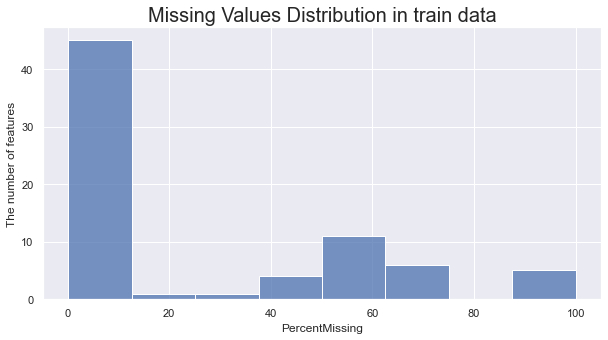

In [11]:
# Plotting missing value for train data
plt.figure(figsize=(10,5))
sns.histplot(x=train_Percent_Missings_df.PercentMissing).set_title('Missing Values Distribution in train data',size=20)
plt.ylabel('The number of features')

Text(0, 0.5, 'The number of features')

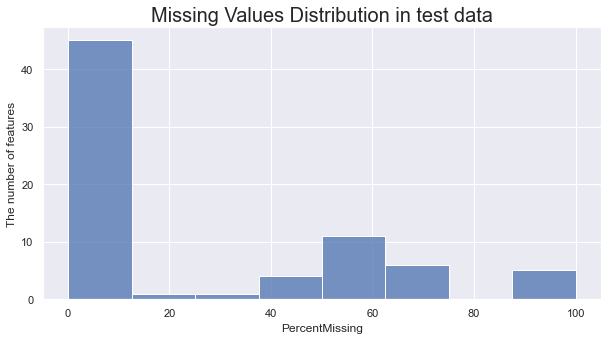

In [13]:
# Plotting missing value for test data
plt.figure(figsize=(10,5))
sns.histplot(x=test_Percent_Missings_df.PercentMissing).set_title('Missing Values Distribution in test data',size=20)
plt.ylabel('The number of features')

 Dropping Featurees with more tha 25% missing value

In [14]:
#Get columns with more than 25% missing values
Missings_more_than_25_train = train_Percent_Missings_df[train_Percent_Missings_df.PercentMissing>25]
Missings_more_than_25_test = test_Percent_Missings_df[test_Percent_Missings_df.PercentMissing>25]

#Drop from train and test 
train_df = train_df.drop(list(Missings_more_than_25_train.Feature), axis=1)
test_df=test_df.drop(list(Missings_more_than_25_test.Feature),axis=1)

In [15]:
print(train_df.shape)
print(test_df.shape)

(70000, 482)
(30000, 481)


 Numerical vs Categorical Features

In [16]:
#Numeric
Num_Features = train_df.columns[train_df.dtypes !='object'].values[2:]

#Categorical
Cat_Features = train_df.columns[train_df.dtypes =='object'].values
print(len(Num_Features))
print(len(Cat_Features))

393
87


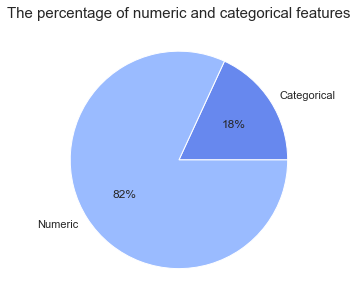

In [17]:
#Viewing the distribution using Pie chart
pichrt = [len(Cat_Features),len(Num_Features)]
colors = sns.color_palette('coolwarm')
plt.figure(figsize=(10,5))
plt.title('The percentage of numeric and categorical features',size=15)
plt.pie(pichrt, colors = colors, labels=['Categorical','Numeric'] ,autopct = '%0.0f%%')
plt.show()

## Replacing Missing Values

In [18]:
#Replacing Categorical Variables with Mode
def get_mode(feature,df):
    return df[feature].mode()[0]

for col in Cat_Features:
    train_df[col].fillna(get_mode(col,train_df),inplace=True)
    test_df[col].fillna(get_mode(col,test_df),inplace=True)

In [19]:
#Replacing Numerical variables with median
for col in Num_Features:
    train_df[col].fillna(train_df[col].median(),inplace=True)
    test_df[col].fillna(test_df[col].median(),inplace=True)

In [ ]:
train_df.info()

## Handelling Date Features

In [20]:
# Find columns that contain date objects
mask = train_df[Cat_Features][:10].astype(str).apply(lambda x : x.str.match('(\d{2,4}(-|\/|\\|\.| )\d{2}(-|\/|\\|\.| )\d{2,4})+').any())
date_Features=train_df[Cat_Features].loc[:,mask]

date_Features

,feature_191,feature_192,feature_199,feature_200,feature_201
0,11/10/2017,11/10/2017,11/10/2017,17/01/2016,11/10/2017
1,25/03/2015,25/03/2015,02/04/2017,25/03/2015,25/03/2015
2,27/01/2015,27/01/2015,24/03/2016,27/01/2015,27/01/2015
3,05/02/2014,01/04/2014,01/04/2014,01/04/2014,01/04/2014
4,20/07/2009,10/09/2013,10/09/2013,24/01/2016,10/09/2013
...,...,...,...,...,...
69995,27/09/2010,01/02/2014,01/02/2014,14/02/2014,01/02/2014
69996,19/09/2016,19/09/2016,19/09/2016,19/09/2016,19/09/2016
69997,14/09/2005,25/07/2015,25/07/2015,09/04/2016,25/07/2015
69998,29/11/2017,29/11/2017,29/11/2017,17/01/2016,29/11/2017


In [21]:
# Change these columns to Datetime
train_df[date_Features.columns] = train_df[date_Features.columns].apply(pd.to_datetime,dayfirst = False)
test_df[date_Features.columns] = test_df[date_Features.columns].apply(pd.to_datetime,dayfirst = False)

#Show date columns
shw_dateCol = train_df[train_df.columns[train_df.dtypes =='datetime64[ns]']]
shw_dateCol

,feature_191,feature_192,feature_199,feature_200,feature_201
0,2017-11-10,2017-11-10,2017-11-10,2016-01-17,2017-11-10
1,2015-03-25,2015-03-25,2017-02-04,2015-03-25,2015-03-25
2,2015-01-27,2015-01-27,2016-03-24,2015-01-27,2015-01-27
3,2014-05-02,2014-01-04,2014-01-04,2014-01-04,2014-01-04
4,2009-07-20,2013-10-09,2013-10-09,2016-01-24,2013-10-09
...,...,...,...,...,...
69995,2010-09-27,2014-01-02,2014-01-02,2014-02-14,2014-01-02
69996,2016-09-19,2016-09-19,2016-09-19,2016-09-19,2016-09-19
69997,2005-09-14,2015-07-25,2015-07-25,2016-09-04,2015-07-25
69998,2017-11-29,2017-11-29,2017-11-29,2016-01-17,2017-11-29


In [22]:
# Extracting Year from date Using DatetimeIndex
for col in shw_dateCol.columns:
    train_df[col+"_year"]=pd.DatetimeIndex(train_df[col]).year
    test_df[col+"_year"]=pd.DatetimeIndex(test_df[col]).year


In [23]:
# Drop Date Features since we will only consider the Year
train_df.drop(list(shw_dateCol.columns),axis=1,inplace=True)
test_df.drop(list(shw_dateCol.columns),axis=1,inplace=True)

In [24]:
#Update Categorical_Features list
Cat_Features = [i for i in Cat_Features if i not in shw_dateCol.columns]

# Handeling Categorical Features

In [25]:
# Creating Copy of data
train_c = train_df.copy()
test_c = test_df.copy()

In [26]:
# Unique values for each Categorical Feature
def get_cardinality(df,otype):
    tmp=[]
    for col in otype:
        tmp.append( df[col].nunique() )

    cardinality = pd.DataFrame({'Features':otype,'Cardinality':tmp})
    return cardinality.sort_values(by='Cardinality',ascending=False)

# Categorical Features Sorted by cardinality 
cat_cardinality = get_cardinality(train_c,Cat_Features).head(10)
cat_cardinality

,Features,Cardinality
7,feature_18,15858
28,feature_133,7126
9,feature_20,5841
11,feature_22,2339
10,feature_21,2327
8,feature_19,260
24,feature_54,260
35,feature_185,255
48,feature_246,147
63,feature_279,136


In [27]:
# Checking for values that has only one count
print(train_c['feature_18'].value_counts()[train_c['feature_18'].value_counts()<2].count())
print(train_c['feature_133'].value_counts()[train_c['feature_133'].value_counts()<2].count())

7181
4916


There are 7181 unique values out of 15858 that come up only once in the entire dataset for 'feature_18'.

There are 4916 unique values out of 7126 that come up only once in the entire dataset for 'feature_133'.

We need to reduce the cardinality of the Categorical variables. We will replace the value which comes only once as "other".

In [28]:
# Replacing value which comes only once to "other"
for col in list(cat_cardinality.Features):
    tmp = list(train_c[col].value_counts()[train_c[col].value_counts()<2].index)
    train_c[col] = train_c[col].apply(lambda i:'other' if i in tmp else i)

# Repeating the same step for test data
for col in list(cat_cardinality.Features):
    tmp = list(test_c[col].value_counts()[test_c[col].value_counts()<2].index)
    test_c[col] = test_c[col].apply(lambda i:'other' if i in tmp else i)

 Chi-Square Hypotheis Test for Indepence for Categorical Features

- p-value = 0.05

- Null Hypothesis (Ho): The 'Target' Variable is independent on the Cat_Features

- Alternate Hypothesis (Ha): The 'Target' Variable is dependent on the Cat_Features

In [29]:
# Importing chi-square
from scipy.stats import chi2_contingency

chi2_result = []
for i in Cat_Features:
    if chi2_contingency(pd.crosstab(train_df['target'],train_df[i]))[1] < 0.05:
        chi2_result.append('Reject Null Hypothesis')
    else:
        chi2_result.append('Fail to Reject Null Hypothesis')
        
result = pd.DataFrame({'Column':Cat_Features, 'HypotheisisResult': chi2_result})
result

,Column,HypotheisisResult
0,feature_0,Fail to Reject Null Hypothesis
1,feature_1,Fail to Reject Null Hypothesis
2,feature_2,Reject Null Hypothesis
3,feature_3,Reject Null Hypothesis
4,feature_4,Reject Null Hypothesis
...,...,...
77,feature_293,Reject Null Hypothesis
78,feature_336,Reject Null Hypothesis
79,feature_337,Fail to Reject Null Hypothesis
80,feature_338,Fail to Reject Null Hypothesis


We will drop the features to drop list which is "Fail to Reject Null Hypothesis"

In [ ]:
# Adding the features to drop list - Unwanted_Cat_Features
Unwanted_Cat_Features = result[result.HypotheisisResult == 'Fail to Reject Null Hypothesis'].Column.values

#Creating a drop list
Features_toDrop=[]
Features_toDrop += list(Unwanted_Cat_Features)
print('Number of Categorical variables that are not dependent on variable target = ',len(Unwanted_Cat_Features))

# Handeling Numeric Features

Correlations between numeric columns and target

In [ ]:
corr_df=train_c.drop(['target'],axis=1).corrwith(train_c['target']).abs().sort_values(ascending=False)
corr_df

In [ ]:
# Distribution of numeric features in terms of correlation
plt.figure(figsize=(10,5))
plt.xlabel('Correlation with target')
plt.ylabel('The number of numeric features')
sns.histplot(corr_df).set_title('Distribution of numeric features in terms of correlation with the target',size=15)
plt.show()

In [ ]:
#Plot features which have more than 0.08 correlation with the target (sorted)
plt.figure(figsize=(10,10))
sns.barplot(x=corr_df[corr_df>0.08],y=corr_df[corr_df>0.08].index).set_title('Correlation between numeric features and target')
plt.xlabel('Correlation')

feature_307 is the only feature with correlation coefficient value greater than 0.3 and it
is binary just like the 'target' column.

In [ ]:
# Listing top 12 features 
corr_df[corr_df>0.08].head(12).sort_values(ascending=False)

In [ ]:
# Ploting top 10 features 
fig, ax = plt.subplots(3,3,figsize=(17,12))
sns.histplot(train_c.feature_81, ax=ax[0][0])
sns.histplot(train_c.feature_82, ax=ax[0][1])
sns.countplot(train_c.feature_307,hue=train_c.target, ax=ax[0][2])
sns.countplot(train_c.feature_297,hue=train_c.target, ax=ax[1][0])
sns.countplot(train_c.feature_108,hue=train_c.target, ax=ax[1][1])
sns.countplot(train_c.feature_110,hue=train_c.target, ax=ax[1][2])
sns.countplot(train_c.feature_470,hue=train_c.target, ax=ax[2][0])
sns.countplot(train_c.feature_264,hue=train_c.target, ax=ax[2][1])
sns.countplot(train_c.feature_263,hue=train_c.target, ax=ax[2][2])
plt.suptitle('Important numeric features')
plt.show()

Adding New Feature

In [48]:
#Binarization feature_82
train_c['feature_82_binary']= train_c['feature_82'].apply(lambda x: 0 if x==0 else 1)
test_c['feature_82_binary']= test_c['feature_82'].apply(lambda x: 0 if x==0 else 1)

In [49]:
#Taking sqrt of feature_81
train_c['feature_81_sqrt']= train_c.feature_81.apply(np.sqrt)
test_c['feature_81_sqrt']= test_c.feature_81.apply(np.sqrt)

In [50]:
#Multiplication of feature_307 and feature_82_binary
train_c['feature_82_307']= train_c['feature_307']*train_c['feature_82_binary']
test_c['feature_82_307']= test_c['feature_307']*test_c['feature_82_binary']

Adding features to drop list that have insignificant correlation with 'target' variable

In [51]:
#Corr less than 0.002 with target
corr_low=list(corr_df[corr_df<0.002].index)

#Add to drop list
Features_toDrop+=corr_low
print(len(corr_low),' features added to drop list')

28  features added to drop list


Adding Features with one value to drop list

In [53]:
# Find columns with one value
Col_with_OneValue=[]
for col in train_c.columns:
    if (( train_c[col].nunique() <=1 )):
        Col_with_OneValue.append(col)
train_c[Col_with_OneValue]

#Add to drop list
Features_toDrop +=list(Col_with_OneValue)
print(len(Col_with_OneValue),' features added to drop list')

59  features added to drop list


Finding Correlation between num columns

In [87]:
get_corr_df = train_c[Num_Features].corr()
get_corr_df = get_corr_df[get_corr_df > 0.9]


In [ ]:
get_corr_df.count

There are columns with corr >0.9 

In [ ]:
# Getting features that have corr >= 0.9
corr_features = np.where(np.abs(get_corr_df) > 0.9)

# To remove self corr of feature and avoiding duplication
corr_features = [(get_corr_df.iloc[x,y], x, y) for x, y in zip(*corr_features) if x != y and x < y]

# Looping through array to create df
p,q,r = list(),list(),list()
for x,y,z in corr_features:
    p.append(get_corr_df.index[y])
    q.append(get_corr_df.columns[z])
    r.append(x)
corr_arr = pd.DataFrame([p,q,r], index=['C1', 'C2', 'Corr']).T
corr_arr

We will drop one column from the pair to avoid multicolinearity

In [104]:
high_corr_mul_drop = list( set(corr_arr.C1[corr_arr.Corr > 0.9])) +  list(set(corr_arr.C1[corr_arr.Corr <-0.9]))
Features_toDrop += high_corr_mul_drop
print(len(high_corr_mul_drop),' features added to drop list')


188  features added to drop list


# Dropping the unnecessary features

In [ ]:
Features_toDrop=list(set(Features_toDrop))

train_c.drop(Features_toDrop,axis=1,inplace=True)
test_c.drop(Features_toDrop,axis=1,inplace=True)

print(len(Features_toDrop),' Features dropped')
print(train_c.shape) 
print(test_c.shape)

# Encoding Cat_Features

In [116]:
#Create copy
train_m = train_c.copy()
test_m = test_c.copy()

#Remove dropped Columns from Cat_Features list
Cat_Features = [i for i in Cat_Features
                        if i not in Features_toDrop]

# Encoding categorical features
for i in list(Cat_Features):
    Lab_En = LabelEncoder()
    Lab_En.fit(pd.concat([train_m[i],test_m[i]], ignore_index=True))

    # Transform 
    train_m[i] = Lab_En.transform(train_m[i])
    test_m[i] = Lab_En.transform(test_m[i])

# ** WORK IN PROGRESS **

## Resources:

- The Confusionj Matrix: https://www.youtube.com/watch?v=Kdsp6soqA7o
- ROC and AUC: https://www.youtube.com/watch?v=4jRBRDbJemM
- Chi Square: https://www.jmp.com/en_be/statistics-knowledge-portal/chi-square-test.html
- Chi Square: https://www.analyticsvidhya.com/blog/2019/11/what-is-chi-square-test-how-it-works/